In [1]:
# import packages
import os
import cv2
import numpy as np;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album
import math

from sklearn import model_selection
from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import joblib
import time
import wandb
import random
import itertools

class CaImagesDataset(Dataset):
    """CA Images dataset."""
    # load the dataset
    def __init__(self, x, y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    # number of samples in the dataset
    def __len__(self):
        return len(self.x)
    
    # get a sample from the dataset
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]
    
class NeuralNetworkClassifier(nn.Module):
    """Neural network with LSTM layer and fully connected layer"""
    def __init__(self):
        super(NeuralNetworkClassifier,self).__init__()
        self.lstm = nn.LSTM(input_size=2, 
                            hidden_size=1,
                            bidirectional=False,
                            num_layers=1,
                            batch_first=True
                            )

    def forward(self,x):
        output,_status = self.lstm(x)
        return output

def find_centroids(segmented_img: np.ndarray) -> Tuple[List, List]:
  """
  Finds centroids and contours of segmented image
  
  Parameters
  ----------
  segmented_img: segmented image (binary)
  
  Returns
  -------
  centroids: list of centroids in image
  contours: list of contours in image
  """
  # initialize centroids list
  centroids = []
  # get contours
  contours, hierarchy = cv2.findContours(segmented_img, 
                          cv2.RETR_EXTERNAL, 
                          cv2.CHAIN_APPROX_SIMPLE)
  
  # compute the centroid of each contour
  for c in contours:
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX, cY))
  
  return centroids, contours

def crop_img(img: np.array, coordinate: Tuple, crop_width: int = 20, crop_height: int = 20) -> np.array:
  """
  Crop image around given coordinate.
  
  Parameters
  ----------
  img: image to crop
  position: point to crop around
  crop_width: width of crop
  crop_height: height of crop
  
  Returns
  -------
  cropped image of shape (crop_width, crop_height)
  """
  x, y = coordinate
  return img[max(0, y-(crop_height//2)): min(img.shape[0], y+(crop_height//2)),
              max(0, x-(crop_width//2)): min(img.shape[1], x+(crop_width//2))]

def get_dist_score(point1:Tuple, point2:Tuple) -> float:
  """Returns distance score between two points
  
  Parameters
  ----------
  point1: coordinates of point 1
  point2: coordinates of point 2
  
  Returns
  -------
  Euclidean distance between point1 and point2
  """
  x, y = point1
  x2, y2 = point2
  
  return math.sqrt(((x2-x)**2)+((y2-y)**2))

def get_color_score(img1: np.array, img2: np.array, compare_type: int = cv2.HISTCMP_CORREL) -> float:
    """Returns color score between two images
    
    Parameters
    ----------
    img1: First image
    img2: Second image
    compare_type: Type of opencv histogram comparison to use
    
    Returns
    -------
    Histogram similarity between the two images
    
    Related
    -------
    See https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
    """
    hst1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hst2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
    score = cv2.compareHist(hst1, hst2, cv2.HISTCMP_CORREL)
    return score

def get_shape_score(cont1 , cont2) -> float:
    """ Get difference in area and perimeter between two contours

    Parameters
    ----------
        cont1 (contour): First contour
        cont2 (contour): Second contour

    Returns
    -------
        Tuple : the absolute value of difference in area and perimeter
        
    Related
    -------
    See https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html 
    """
    area1 = cv2.contourArea(cont1)
    area2 = cv2.contourArea(cont2)
    perimeter1 = cv2.arcLength(cont1, True)
    perimeter2 = cv2.arcLength(cont2, True)
    return abs(area1 - area2), abs(perimeter1-perimeter2)

def get_closest_cent(centroids:List, point:Tuple):
  """ Returns the closest centroid to the predicted coordinates
  centroids: list of centroids
  pred: predicted coordinates"""
  min_score = 10**1000
  closest_centroid = (0,0) # Closest to predicted coords

  for centroid in centroids:
    score = get_dist_score(point, centroid)
    if score <= min_score:
      min_score = score
      closest_centroid = centroid
  return closest_centroid

def get_most_similar_centroid(img, prev_img, pred_pt:Tuple, prev_pt:Tuple, centroids: List[Tuple], contours: List, dist_weight: int = 1, color_weight: int = 10, area_weight:int = 0, log=False):
    """ 
    Returns the closest centroid to the predicted coordinates
    
    Parameters
    ----------
    img: image for this frame
    prev_img: image for previous frame
    pred_pt: predicted coordinate
    prev_pt: previous coordinate
    centroids: list of centroids
    contours: list of contours
    dist_weight: weighting of distance score (Default is 1)
    color_weight: weighting of color score (Default is 10)
    area_weight: weighting of area score (Default is 0)
    
    Returns
    -------
    Tuple: closest centroid (closest in terms of weighted distance, color, and area)
    """
    cropped_prev_img = crop_img(prev_img, prev_pt)
    prev_centroids, prev_contours = find_centroids(cropped_prev_img)
    prev_contour = prev_contours[0]
    
    min_score = 10**1000
    closest_centroid = (0,0)

    # Loop through potential centroids
    for i in range(len(centroids)):
        # Get centroid, contour, and cropped centroid image for this centroid
        centroid = centroids[i]
        contour = contours[i]
        cropped_centroid_img = crop_img(img, centroid)
        
        # Get scores for this centroid
        dist_score = get_dist_score(pred_pt, centroid) # Distance between predicted point and centroid
        color_score = get_color_score(cropped_centroid_img, cropped_prev_img) # Color similarity between cropped centroid and cropped previous point
        area_score, perimeter_score = get_shape_score(contour, prev_contour) # Area and perimeter difference between this contour and previous contour
        
        # Weighted score
        score = (dist_weight*dist_score) + (color_weight*color_score) + (area_weight*area_score)
        
        # Print scores for each centroid
        if log:
            print(f"Centroid: {centroid} | Score: {score:.2f} | Dist: {dist_score:.2f}, Color: {color_score:.3f}, Area: {area_score:.2f}")
        
        # Check if this centroid is closer than the previous closest
        if score <= min_score:
            min_score = score
            closest_centroid = centroid
            
    return closest_centroid

def show_crop_images(img, mask, prev_img, act_pt, pred_pt, prev_pt, cnts, contours):
    cropped_prev_img = crop_img(prev_img, prev_pt)
    num_centroids = len(centroids)
    cropped_imgs = []
    for i in range(num_centroids):
      # Crop image around centroid
      cnt = cnts[i]
      cont = contours[i]
      cropped_img = crop_img(img, cnt)
      cropped_imgs.append(cropped_img)
        # Visualize each cropped centroid and their respective scores
    
    closest = get_most_similar_centroid(img, prev_img, pred_pt, prev_pt, cnts, contours)
    closest_act = get_closest_cent(cnts, act_pt)
    
    fig, ax = plt.subplots(1, num_centroids+5)
    ax[0].imshow(prev_img)
    ax[0].plot(prev_pt[0], prev_pt[1], 'ro', markersize=3, label= "Previous")
    ax[0].set_title(f"Previous Img: Frame {frame-1}")
    ax[1].imshow(cropped_prev_img) # Plot previous cropped
    ax[1].set_title("Previous Cropped")
    ax[2].imshow(img)
    ax[2].set_title(f"Current Img: Frame {frame}")
    ax[2].plot(act_pt[0], act_pt[1], 'ro', markersize=3, label= "Actual")
    ax[2].plot(pred_pt[0], pred_pt[1], 'bo', markersize=3, label = "Predicted")
    ax[2].plot(closest[0], closest[1], 'mo', markersize=3, label = "Closest Predicted")
    ax[2].plot(closest_act[0], closest_act[1], 'go', markersize=3, label = "Closest Actual")
    ax[3].imshow(mask)
    ax[3].set_title("Mask")
    for i in range(num_centroids):
      ax[3].plot(cnts[i][0], cnts[i][1], 'ro', markersize=1, label= f"Centroid {i}")
      ax[i+4].imshow(cropped_imgs[i]) # Plot centroid cropped
      title = f"Cnt {cnts[i]}"
      if cnts[i] == closest:
        title += " | Pred"
      if cnts[i] == closest_act:
        title += " | Act"
      ax[i+4].set_title(title)
    # ax[3].legend()
    ax[-1].imshow(crop_img(img, act_pt.astype(int), crop_size, crop_size))
    ax[-1].set_title("Actual Cropped")
    plt.show()

In [2]:

data_dir = "/Users/huayinluo/Desktop/code/catracking-1/data"
video_dir = os.path.join(data_dir, "imgs")
position_dir = os.path.join(data_dir, "positions")
model_dir = "/Users/huayinluo/Desktop/code/catracking-1/models/lstm"
img_dir = "/Users/huayinluo/Desktop/code/catracking-1/images"
results_dir = "/Users/huayinluo/Desktop/code/catracking-1/results"

In [3]:

# Preprocessing
data_dir = "/Users/huayinluo/Desktop/code/catracking-1/data"
video_dir = os.path.join(data_dir, "imgs")
position_dir = os.path.join(data_dir, "positions")
model_dir = "/Users/huayinluo/Desktop/code/catracking-1/models/lstm_classify"
img_dir = "/Users/huayinluo/Desktop/code/catracking-1/images"
results_dir = "/Users/huayinluo/Desktop/code/catracking-1/results"

# Save all video positions in dictionary
videos = ['11408', '11409', "11410", '11411']
positions_dct={} # Dictionary of video: positions
for video in videos:
  AVA_positions = np.load(os.path.join(position_dir, f"AVA_{video}.mat.npy"))
  AVB_positions = np.load(os.path.join(position_dir, f"AVB_{video}.mat.npy"))
  all_neurons_positions = np.stack((AVA_positions, AVB_positions))
  positions_dct[video] = all_neurons_positions
  print(f"Loading {video}...")
print(f"Finished loading images and positions: {len(positions_dct)} positions")

# Original data test/train split (# Add 80% of each video to training set, 20% to testing set)
train_sequences = []
test_sequences = []
for video in videos:
  all_positions = positions_dct[video]
  height, width = cv2.imread(f"/Users/huayinluo/Desktop/code/catracking-1/images/original/{video}/0.png").shape[:2]
  norm_positions = np.multiply(all_positions, [1/width, 1/height])
  split = math.floor(norm_positions.shape[1]*0.8)
  train_sequences.append(norm_positions[:, :split, :])
  test_sequences.append(norm_positions[:, split:, :])
print("Test/Train split complete")

# Set sequence length for consistent array shape
sequence_length = 2000

# Create labelled training data (with shuffled sequences)
train_sequences_with_shuffled = []
train_labels_with_shuffled = []
for ava_sequence, avb_sequence in train_sequences:   
    # Add full correct sequence for two neurons
    train_sequences_with_shuffled.append(ava_sequence[:sequence_length])
    train_labels_with_shuffled.append(np.ones(sequence_length))

    train_sequences_with_shuffled.append(avb_sequence[:sequence_length])
    train_labels_with_shuffled.append(np.zeros(sequence_length))
    
    shuffled_sequences = []
    # Add shuffled sequences of two neurons
    for i in range(1, sequence_length, 10):
        # Label for shuffled sequence
        shuffled_sequence_label = np.concatenate((np.ones(i), np.zeros(sequence_length-i)))
        np.random.shuffle(shuffled_sequence_label)
        
        # Get coordinate values for shuffled sequence based on labels
        shuffled_sequence = shuffled_sequence_label.copy()
        shuffled_sequence = np.expand_dims(shuffled_sequence, axis=1) # add axis
        shuffled_sequence = np.repeat(shuffled_sequence, 2, axis=1) # repeat for x and y
        for j in range(sequence_length):
            # Labels: 1 is AVA, 0 is AVB
            shuffled_sequence[j] = ava_sequence[j] if shuffled_sequence_label[j] == 1 else avb_sequence[j]
        
        # Add shuffled sequence & label to training data
        train_sequences_with_shuffled.append(shuffled_sequence)
        train_labels_with_shuffled.append(shuffled_sequence_label)
        print(f"Added shuffled sequence {i} for video {video}")

print(f"Train sequences: {len(train_sequences_with_shuffled)}")
train_sequences_with_shuffled = np.stack(train_sequences_with_shuffled)
train_labels_with_shuffled = np.stack(train_labels_with_shuffled)

# Create labelled testing data (with shuffled sequences)
test_sequences_with_shuffled = []
test_labels_with_shuffled = []
test_sequence_length = 200 # Test sequences are shorter
for ava_sequence, avb_sequence in test_sequences:   
    test_sequences_with_shuffled.append(ava_sequence[:test_sequence_length])
    test_labels_with_shuffled.append(np.ones(test_sequence_length))
    test_sequences_with_shuffled.append(avb_sequence[:test_sequence_length])
    test_labels_with_shuffled.append(np.zeros(test_sequence_length))

    shuffled_sequences = []
    for i in range(1, test_sequence_length, 10):
        shuffled_sequence_label = np.concatenate((np.ones(i), np.zeros(test_sequence_length-i)))
        np.random.shuffle(shuffled_sequence_label)
        shuffled_sequence = shuffled_sequence_label.copy()
        shuffled_sequence = np.expand_dims(shuffled_sequence, axis=1) # add axis
        shuffled_sequence = np.repeat(shuffled_sequence, 2, axis=1) # repeat for x and y
        for j in range(test_sequence_length):
            shuffled_sequence[j] = ava_sequence[j] if shuffled_sequence_label[j] == 1 else avb_sequence[j]
        test_sequences_with_shuffled.append(shuffled_sequence)
        test_labels_with_shuffled.append(shuffled_sequence_label)
print(f"Test sequences: {len(test_sequences_with_shuffled)}")
test_sequences_with_shuffled = np.stack(test_sequences_with_shuffled)
test_labels_with_shuffled = np.stack(test_labels_with_shuffled)


Loading 11408...
Loading 11409...
Loading 11410...
Loading 11411...
Finished loading images and positions: 4 positions
Test/Train split complete
Added shuffled sequence 1 for video 11411
Added shuffled sequence 11 for video 11411
Added shuffled sequence 21 for video 11411
Added shuffled sequence 31 for video 11411
Added shuffled sequence 41 for video 11411
Added shuffled sequence 51 for video 11411
Added shuffled sequence 61 for video 11411
Added shuffled sequence 71 for video 11411
Added shuffled sequence 81 for video 11411
Added shuffled sequence 91 for video 11411
Added shuffled sequence 101 for video 11411
Added shuffled sequence 111 for video 11411
Added shuffled sequence 121 for video 11411
Added shuffled sequence 131 for video 11411
Added shuffled sequence 141 for video 11411
Added shuffled sequence 151 for video 11411
Added shuffled sequence 161 for video 11411
Added shuffled sequence 171 for video 11411
Added shuffled sequence 181 for video 11411
Added shuffled sequence 191 fo

In [4]:
train_sequences_with_shuffled.shape

(808, 2000, 2)

In [6]:
test_sequences_with_shuffled.shape

(88, 200, 2)

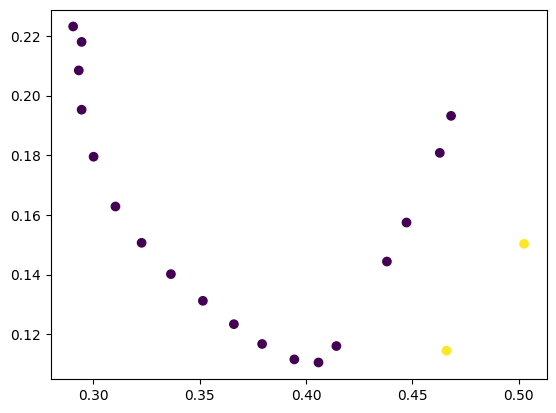

In [10]:
seq_num = 10
end_frame = 200
plt.scatter(train_sequences_with_shuffled[seq_num, :end_frame, 0], train_sequences_with_shuffled[seq_num, :end_frame, 1], c=train_labels_with_shuffled[seq_num, :end_frame])

In [ ]:

# Initialise model and parameters
model = NeuralNetworkClassifier()
model_name = "lstm_classifier_1"

epochs = 50
learning_rate = 0.00001
batch_size = 16
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

TRAINING = True
TESTING = False
if TRAINING:
  # Initialise wandb
  wandb.init(
      project="lstm-classify",
      config={
      "existing_model": "none",
      "model_name": model_name,
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "epochs": epochs,
      }
  )

  # Train model
  start_time = time.time()
  for epoch in range(epochs):
      num_batches = len(train_sequences_with_shuffled) // batch_size
      for j in range(num_batches - 1):
          input_sequences = torch.tensor(train_sequences_with_shuffled[j*batch_size:(j+1)*batch_size], dtype=torch.float32) # Shape: [N: batch size (16), L: sequence length (2000), H: input dimension (2))]
          input_labels = torch.tensor(train_labels_with_shuffled[j*batch_size:(j+1)*batch_size], dtype=torch.float32) # Shape: [N: batch size (8), L: sequence length (100), H: input dimension (2))]
          pred = model(input_sequences)
          loss = criterion(pred.squeeze(2), input_labels) # Squeeze to remove dimension of size 1 [N, L, 1] -> [N, L]
          loss.backward()
          optimizer.step()
          if j % 10 == 0:
              print(f"Epoch: {epoch} | Batch: {j} | Loss: {loss}")
      if epoch % 10 == 0:
          wandb.log({"loss": loss})
          test_input_sequences = torch.tensor(test_sequences_with_shuffled[:batch_size], dtype=torch.float32) # Shape: [N: batch size (8), L: sequence length (100), H: input dimension (2))]
          test_input_labels = torch.tensor(test_labels_with_shuffled[:batch_size], dtype=torch.float32) # Shape: [N: batch size (8), L: sequence length (100), H: input dimension (2))]
          test_pred = model(test_input_sequences)
          test_loss = criterion(test_pred.squeeze(2), test_input_labels)
          wandb.log({"valid_loss": test_loss})
          print(f"Epoch: {epoch} | Loss: {loss} | Valid Loss: {test_loss}")
      joblib.dump(model, os.path.join(model_dir, model_name))
  print(time.time() - start_time)
  wandb.finish()
  

In [ ]:

if TESTING:
  model = joblib.load(os.path.join(model_dir, model_name))
  sequence_num = 0
  train_input_sequence = torch.tensor(train_sequences_with_shuffled[sequence_num], dtype=torch.float32)
  train_input_label = torch.tensor(train_labels_with_shuffled[sequence_num], dtype=torch.float32)
  test_input_sequence = torch.tensor(test_sequences_with_shuffled[sequence_num], dtype=torch.float32)
  test_input_label = torch.tensor(test_labels_with_shuffled[sequence_num], dtype=torch.float32)
  
  train_pred = model(train_input_sequence)
  loss = criterion(train_pred.squeeze(2), train_input_label)
